In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('~/Downloads/conversion_data.csv')
df['country'] = df['country'].astype('category')
df['source'] = df['source'].astype('category')

In [3]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


The max age is 123, but the 75% age is only 36.

In [4]:
sorted(df['age'],reverse=True)[:10]

[123, 111, 79, 77, 73, 72, 70, 70, 69, 69]

There are two unrealistic ages (123 and 111) so I will remove them.

In [7]:
print(df.loc[df['age']==123])
print(df.loc[df['age']==111])

       country  age  new_user source  total_pages_visited  converted
90928  Germany  123         0    Seo                   15          1
       country  age  new_user source  total_pages_visited  converted
295581      UK  111         0    Ads                   10          1


In [9]:
df.drop([90928,295581],inplace=True)

The average conversion rate is 3%.

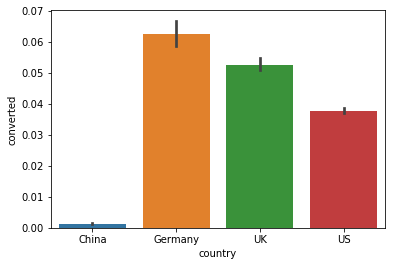

In [6]:
sns.barplot(x='country',y='converted',data=df)

The Chinese users are converting at a significantly lower rate than users from other countries.

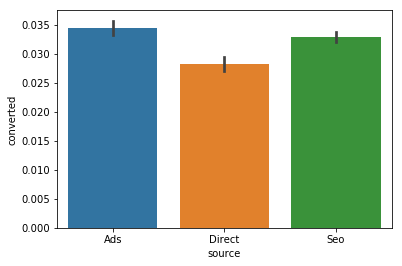

In [10]:
sns.barplot(x='source',y='converted',data=df)

Most people are coming from Ads, followed by Seo, and then direct source.

In [7]:
data_pages = df.groupby('total_pages_visited')[['converted']].mean()

In [26]:
data_ages = df.groupby('age')[['converted']].mean()

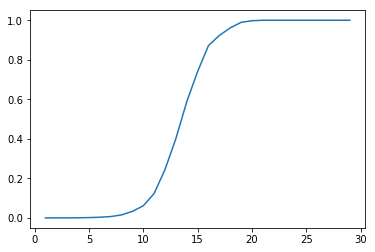

In [8]:
plt.plot(data_pages.index,data_pages['converted'])

This plot shows that as users visit more pages, the probability of conversion increases.

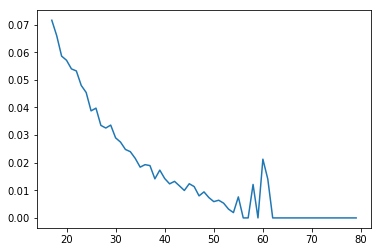

In [27]:
plt.plot(data_ages.index,data_ages['converted'])

This plot shows that as the age of a user increases, the probability of conversion decreases.

In [14]:
df_country = pd.get_dummies(df['country'])
df = pd.concat([df, df_country], axis=1)
df_source = pd.get_dummies(df['source'])
df = pd.concat([df, df_source], axis=1)
df.head()

,country,age,new_user,source,total_pages_visited,converted,China,Germany,UK,US,Ads,Direct,Seo
0,UK,25,1,Ads,1,0,0,0,1,0,1,0,0
1,US,23,1,Seo,5,0,0,0,0,1,0,0,1
2,US,28,1,Seo,4,0,0,0,0,1,0,0,1
3,China,39,1,Seo,5,0,1,0,0,0,0,0,1
4,US,30,1,Seo,6,0,0,0,0,1,0,0,1


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df[['total_pages_visited','China','Germany','UK','US','Ads','Direct','Seo','age','new_user']], df['converted'], test_size=0.33, random_state=42)

In [16]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, np.array(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [25]:
forest.score(X_test,y_test)

0.98436930979625481

The accuracy on the test set is 98%, the baseline accuracy is:

In [29]:
1-sum(df['converted'])/len(df['converted'])

0.967741935483871

Feature ranking:
1. feature 0 (0.809667)
2. feature 8 (0.114073)
3. feature 9 (0.038737)
4. feature 1 (0.020798)
5. feature 4 (0.003662)
6. feature 2 (0.003090)
7. feature 7 (0.002851)
8. feature 5 (0.002533)
9. feature 6 (0.002339)
10. feature 3 (0.002249)


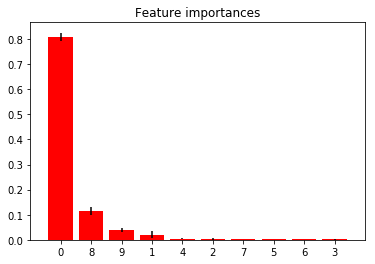

In [26]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

The most important feature is total_pages_visited. However, it is difficult for the company to cause people to visit more pages. Also, people probably visit more pages to buy things anyway, so it is probably caused by the action of a purchase, rather than causing a purchase.

Now I will remove `total_pages_visited` since it is now really helpful to the company.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df[['China','Germany','UK','US','Ads','Direct','Seo','age','new_user']], df['converted'], test_size=0.33, random_state=42)
forest = RandomForestClassifier(random_state=42,class_weight={0: 0.7, 1: 0.3})
forest.fit(X_train, np.array(y_train))

RandomForestClassifier(bootstrap=True, class_weight={0: 0.7, 1: 0.3},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [34]:
forest.score(X_test,y_test)

0.9685565330726621

The accuracy on the test set is now similar to the baseline accuracy.

Feature ranking:
1. feature 8 (0.404159)
2. feature 7 (0.347301)
3. feature 0 (0.137011)
4. feature 2 (0.035515)
5. feature 3 (0.028407)
6. feature 1 (0.024451)
7. feature 5 (0.008243)
8. feature 4 (0.007547)
9. feature 6 (0.007366)


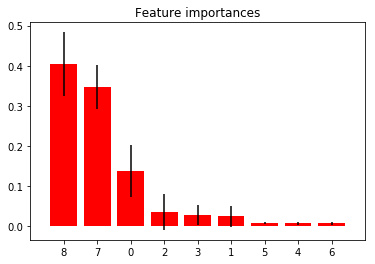

In [35]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

After removing the `total_pages_visited` the most important feature is now whether the user is a new user or not.

In [24]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3,class_weight={0: 0.7, 1: 0.3})
clf.fit(X_train, y_train)

tree.export_graphviz(clf,out_file='tree.dot')

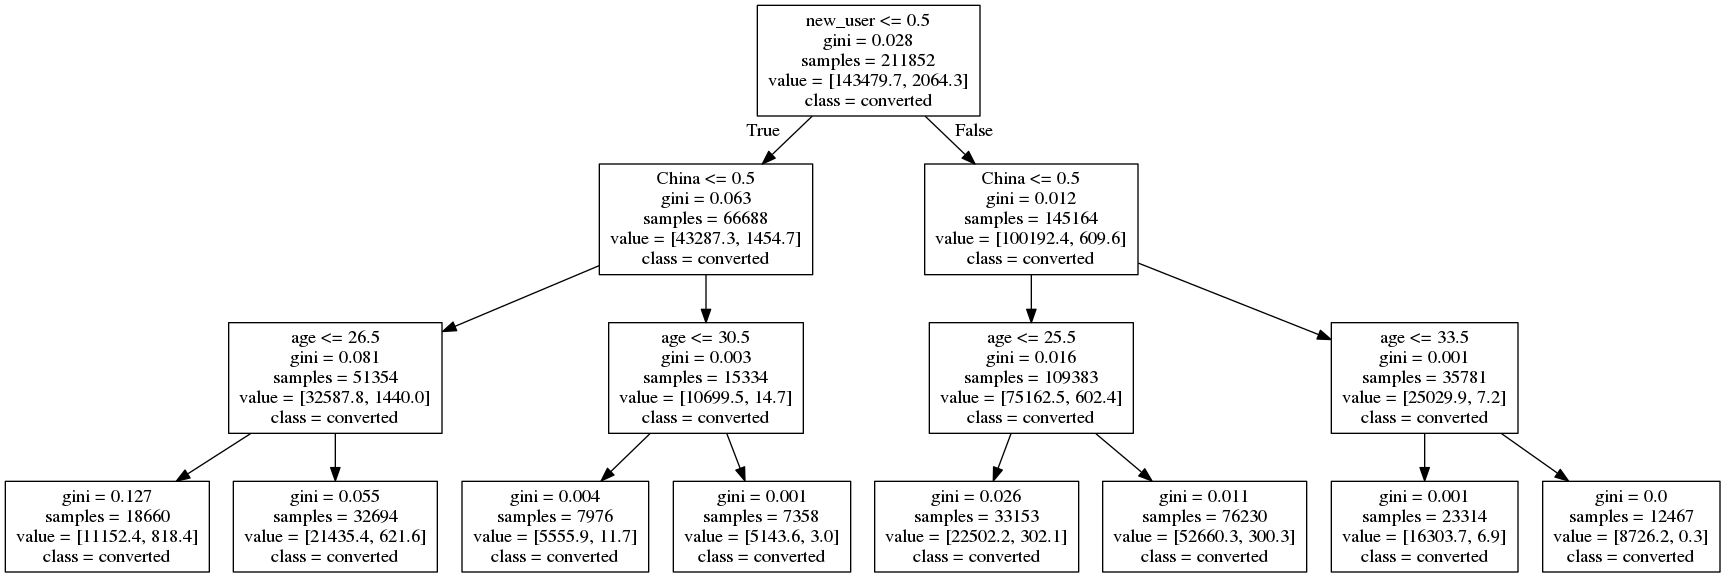

In [25]:
from io import StringIO
import pydotplus
from IPython.display import Image
out = StringIO()
tree.export_graphviz(clf, out_file = out,feature_names=['China','Germany','UK','US','Ads','Direct','Seo','age','new_user'],  
                         class_names=['converted'])
 
graph=pydotplus.graph_from_dot_data(out.getvalue())
Image(graph.create_png())

The first split of the decision tree is whether or not it is a new user. Thus, the site should try to incentivize older users to come back. The next split of the tree is on country, and the tree is split on the user not being from China. Since China has a large population, the site should try to increase the number of Chinese visitors. The third level is split on age. Basically, the site works better for young users (less than about 30 years of age). Thus, the site should advertise towards young people to maximize the conversion rate of their target audience.